# Hands-on Supervised Machine Learning with Python

In this example, we'll predict whether or not an email is spam.

## The Data

You can find the data at the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Spambase).

### Files:

1. [Spam data](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data)
2. [Metadata](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names)
3. [Documentation](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.DOCUMENTATION)

## Reference

__Creators:__

*Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt 
Hewlett-Packard Labs, 1501 Page Mill Rd., Palo Alto, CA 94304 *

__Data Set Information:__

*The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, etc...*

*Our collection of spam e-mails came from our postmaster and individuals who had filed spam. Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam. These are useful when constructing a personalized spam filter. One would either have to blind such non-spam indicators or get a very wide collection of non-spam to generate a general purpose spam filter. *

__For background on spam: __

*Cranor, Lorrie F., LaMacchia, Brian A. Spam! 
Communications of the ACM, 41(8):74-83, 1998. *


In [43]:
from urllib.request import urlretrieve, ProxyHandler, build_opener, install_opener
import requests
import os

pfx = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/"
data_dir = "data"
    
# We might need to set a proxy handler...
try:
    proxies = {"http": os.environ['http_proxy'],
               "https": os.environ['https_proxy']}
    print("Found proxy settings")

    #create the proxy object, assign it to a variable
    proxy = ProxyHandler(proxies)
    # construct a new opener using your proxy settings
    opener = build_opener(proxy)
    # install the opener on the module-level
    install_opener(opener)
    
except KeyError:
    pass


# The following will download the data if you don't already have it...
def get_data(link, where):
    # Append the prefix
    link = pfx + link
    
    # make the parent dir if its not there
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
        
    # download if necessary
    if os.path.exists(where):
        print("Already have %s; will not download" % where)
        return
    
    print("Downloading %s to %s" % (link, where))
    urlretrieve(link, where)
    

# Get the core spam data
get_data(link="spambase.data", where=os.path.join(data_dir, "spam.csv"))

Found proxy settings
Already have data/spam.csv; will not download


## Load and split our data

We've now downloaded the data into the `data/` directory. Let's load it into Pandas and do a bit of exploring...

In [44]:
import pandas as pd

names = ["word_freq_make", "word_freq_address", "word_freq_all", 
         "word_freq_3d", "word_freq_our", "word_freq_over", 
         "word_freq_remove", "word_freq_internet", "word_freq_order", 
         "word_freq_mail", "word_freq_receive", "word_freq_will", 
         "word_freq_people", "word_freq_report", "word_freq_addresses", 
         "word_freq_free", "word_freq_business", "word_freq_email", 
         "word_freq_you", "word_freq_credit", "word_freq_your", 
         "word_freq_font", "word_freq_000", "word_freq_money", 
         "word_freq_hp", "word_freq_hpl", "word_freq_george", 
         "word_freq_650", "word_freq_lab", "word_freq_labs", 
         "word_freq_telnet", "word_freq_857", "word_freq_data", 
         "word_freq_415", "word_freq_85", "word_freq_technology", 
         "word_freq_1999", "word_freq_parts", "word_freq_pm", 
         "word_freq_direct", "word_freq_cs", "word_freq_meeting", 
         "word_freq_original", "word_freq_project", "word_freq_re", 
         "word_freq_edu", "word_freq_table", "word_freq_conference", 
         "char_freq_;", "char_freq_(", "char_freq_[", "char_freq_!", 
         "char_freq_$", "char_freq_#", "capital_run_length_average", 
         "capital_run_length_longest", "capital_run_length_total",
         "is_spam"]

df = pd.read_csv(os.path.join("data", "spam.csv"), header=None, names=names)

# pop off the target
y = df.pop("is_spam")
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

print("Num training samples: %i" % X_train.shape[0])
print("Num test samples: %i" % X_test.shape[0])

Num training samples: 3680
Num test samples: 921


## Fit several models

We're going to fit a series of models and look at how they perform. To evaluate our model, we'll examine learning curves. This will help us diagnose potentially high-variance or high-bias problems.

### Decision tree classifier

Completed fitting 3 folds for train size=920
Completed fitting 3 folds for train size=1533
Completed fitting 3 folds for train size=2146
Completed fitting 3 folds for train size=2760


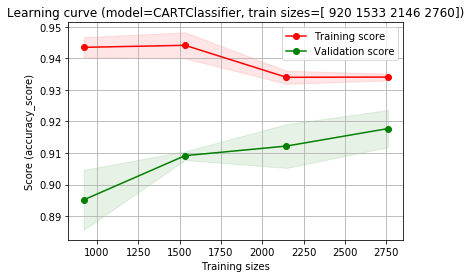

In [46]:
from packtml.utils.plotting import plot_learning_curve
from packtml.decision_tree import CARTClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
# very basic decision tree
plot_learning_curve(
        CARTClassifier, metric=accuracy_score,
        X=X_train, y=y_train, n_folds=3, seed=21, trace=True,
        train_sizes=(np.linspace(.25, .75, 4) * X_train.shape[0]).astype(int),
        max_depth=8, random_state=42)\
    .show()

In [47]:
# Let's fit that decision tree so we can use it later...
decision_tree = CARTClassifier(X_train, y_train, random_state=42, max_depth=8)

### Simple logistic regression

Completed fitting 3 folds for train size=920
Completed fitting 3 folds for train size=1594
Completed fitting 3 folds for train size=2269
Completed fitting 3 folds for train size=2944


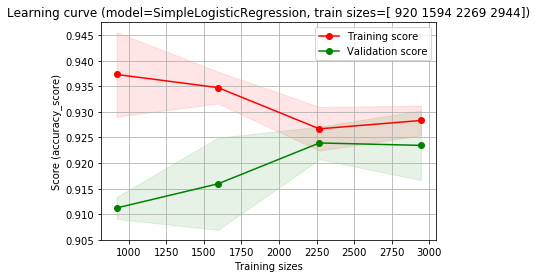

In [48]:
from packtml.regression import SimpleLogisticRegression

# simple logistic regression classifier
plot_learning_curve(
        SimpleLogisticRegression, metric=accuracy_score,
        X=X_train, y=y_train, n_folds=3, seed=21, trace=True,
        train_sizes=(np.linspace(.25, .8, 4) * X_train.shape[0]).astype(int),
        n_steps=250, learning_rate=0.0025, loglik_interval=100)\
    .show()

In [49]:
# Let's fit that logistic regression so we can use it later...
logistic_regression = SimpleLogisticRegression(
    X_train, y_train, n_steps=250, learning_rate=0.0025,
    loglik_interval=100)

## Can they classify emails we make up?

Here is the documentation for the data from UCI:

    | SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)
    |
    | 48 continuous real [0,100] attributes of type word_freq_WORD 
    | = percentage of words in the e-mail that match WORD,
    | i.e. 100 * (number of times the WORD appears in the e-mail) / 
    | total number of words in e-mail.  A "word" in this case is any 
    | string of alphanumeric characters bounded by non-alphanumeric 
    | characters or end-of-string.
    |
    | 6 continuous real [0,100] attributes of type char_freq_CHAR
    | = percentage of characters in the e-mail that match CHAR,
    | i.e. 100 * (number of CHAR occurences) / total characters in e-mail
    |
    | 1 continuous real [1,...] attribute of type capital_run_length_average
    | = average length of uninterrupted sequences of capital letters
    |
    | 1 continuous integer [1,...] attribute of type capital_run_length_longest
    | = length of longest uninterrupted sequence of capital letters
    |
    | 1 continuous integer [1,...] attribute of type capital_run_length_total
    | = sum of length of uninterrupted sequences of capital letters
    | = total number of capital letters in the e-mail
    |
    | 1 nominal {0,1} class attribute of type spam
    | = denotes whether the e-mail was considered spam (1) or not (0), 
    | i.e. unsolicited commercial e-mail.  
    |
    | For more information, see file 'spambase.DOCUMENTATION' at the
    | UCI Machine Learning Repository: http://www.ics.uci.edu/~mlearn/MLRepository.html
    
Let's make some transformers that can transform an email message into a vector of length 48, and then feed them into our algorithms to predict whether they're spam or not.

### The first email (obvious spam):

In [50]:
spam_email = """
Dear small business owner,
    
This email is to inform you that for $0 down, you can receive a 
FREE CREDIT REPORT!!! Your money is important; PROTECT YOUR CREDIT and 
reply direct to us for assistance!
"""

print(spam_email)


Dear small business owner,
    
This email is to inform you that for $0 down, you can receive a 
FREE CREDIT REPORT!!! Your money is important; PROTECT YOUR CREDIT and 
reply direct to us for assistance!



### The second email (not spam):

In [97]:
not_spam = """
Hey George,
    
Make sure to be careful when checking your HP email. There has been a 
phishing attempt recently advertising a credit report. This is a known scam, 
and should be ignored. Please feel free to let me know if you have any
questions or concerns, but the IT guys told me to warn everyone.
"""

print(not_spam)


Hey George,
    
Make sure to be careful when checking your HP email. There has been a 
phishing attempt recently advertising a credit report. This is a known scam, 
and should be ignored. Please feel free to let me know if you have any
questions or concerns, but the IT guys told me to warn everyone.




Now we need to do a bit of finagling to get our emails into a consumable format.

In [98]:
from collections import Counter
import numpy as np

def encode_email(email):
    # tokenize the email
    tokens = email.split()
    
    # easiest way to count characters will be to join everything
    # up and split them into chars, then use a counter to count them
    # all ONE time.
    chars = list("".join(tokens))
    char_counts = Counter(chars)
    n_chars = len(chars)
    
    # we can do the same thing with "tokens" to get counts of words
    # (but we want them to be lowercase!)
    word_counts = Counter([t.lower() for t in tokens])
    
    # Of the names above, the ones that start with "word" are
    # percentages of frequencies of words. Let's get the words
    # in question
    freq_words = [ 
        name.split("_")[-1]
        for name in names 
        if name.startswith("word")
    ]
    
    # compile the first 48 values using the words in question
    word_freq_encodings = [100. * (word_counts.get(t, 0) / len(tokens))
                           for t in freq_words]
    
    # The same applies to names that start with "char". These are the
    # characters that we're interested in counting:  ;, (, [, !, $, #
    freq_chars = [ 
        name.split("_")[-1]
        for name in names 
        if name.startswith("char")
    ]
    
    char_freq_encodings = [100. * (char_counts.get(c, 0) / len(chars))
                           for c in freq_chars]
    
    # now we can compute the more nuanced features that look for
    # runs of capitalization, etc. We can find all the runs of capitals
    # in one single pass of O(N)
    capital_runs = []  # type: list[int]
    in_run = False  # are we currently in a run?
    run_len = 0  # what's the current run len?
    for c in chars:
        capital = c.isupper()
        
        if capital:
            # if we are NOT in a run, we need to start one
            if not in_run:
                in_run = True
            # always increment run length
            run_len += 1
            
        else:
            # if we were NOT in a run, we do not need to do anything.
            # if we WERE in a run, finalize it
            if in_run:
                in_run = False
                capital_runs.append(run_len)
                run_len = 0
                
    # make a np array to compute the next few stats quickly
    capital_runs = np.asarray(capital_runs)
    capital_stats = [capital_runs.mean(), 
                     capital_runs.max(), 
                     capital_runs.sum()]
                
    # return them as a numpy array all concatenated
    return np.array(word_freq_encodings + char_freq_encodings + capital_stats)

In [99]:
# get the email vectors
fake_email = encode_email(spam_email)
real_email = encode_email(not_spam)

# this is what they look like:
print("Spam email:")
print(fake_email)
print("\nReal email:")
print(real_email)

Spam email:
[  0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           2.85714286   0.           0.           0.
   0.           2.85714286   2.85714286   2.85714286   5.71428571
   5.71428571   5.71428571   0.           0.           2.85714286   0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.
   2.85714286   0.           0.           0.           0.           0.           0.
   0.           0.           0.61728395   0.           0.           2.4691358
   0.61728395   0.           7.2         17.          36.        ]

Real email:
[  1.81818182   0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           1.81818182   0.           0.           1.81818182
   1.81818182   1.81818182   0.        

## Let's see if our models are any good!

In [100]:
predict = (lambda rec, mod: "SPAM!" if mod.predict([rec])[0] == 1 else "Not spam")

print("Decision tree predictions:")
print("Spam email prediction: %r" % predict(fake_email, decision_tree))
print("Real email prediction: %r" % predict(real_email, decision_tree))

print("\nLogistic regression predictions:")
print("Spam email prediction: %r" % predict(fake_email, logistic_regression))
print("Real email prediction: %r" % predict(real_email, logistic_regression))

Decision tree predictions:
Spam email prediction: 'SPAM!'
Real email prediction: 'Not spam'

Logistic regression predictions:
Spam email prediction: 'SPAM!'
Real email prediction: 'Not spam'
